In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 
from sklearn.model_selection import train_test_split


# 1. EDA

## Reading data

In [2]:
data = pd.read_csv('book/Ratings.csv')
data.columns = ['UserId', 'BookId', 'Rating']
data

,UserId,BookId,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


Các rating = 0 tương ứng user đã không đánh giá cho item đó nên ta loại bỏ.

In [3]:
data = data.drop(data[data['Rating'] == 0].index)
data

,UserId,BookId,Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


## Basic EDA

In [4]:
# duplicates:
print('-- No of duplicates (by UserId and BookId): ', data.duplicated(subset=['UserId', 'BookId']).sum())
data = data.drop_duplicates(subset=['UserId', 'BookId'], keep='last')

# check nan
print('-- No of nan values: ')
print(data.isna().sum())
data = data.dropna()


# shape:
print('-- Shape of data: ', data.shape)

# infomation:
print('-- Type of data: ')
print(data.dtypes)

# reset index:
data = data.reset_index(drop=True)

# data
print('-- Data')
print(data.head())

-- No of duplicates (by UserId and BookId):  0
-- No of nan values: 
UserId    0
BookId    0
Rating    0
dtype: int64
-- Shape of data:  (433671, 3)
-- Type of data: 
UserId     int64
BookId    object
Rating     int64
dtype: object
-- Data
   UserId      BookId  Rating
0  276726  0155061224       5
1  276729  052165615X       3
2  276729  0521795028       6
3  276736  3257224281       8
4  276737  0600570967       6


## User Rating Frequency

In [5]:
user_freq = data[['UserId', 'BookId']].groupby('UserId').count().reset_index()
user_freq.columns = ['UserId', 'n_ratings']
print(user_freq.head())

   UserId  n_ratings
0       8          7
1       9          1
2      10          1
3      12          1
4      14          3


In [6]:
#Users with most no of rating
most_rated = user_freq.sort_values(by=['n_ratings'], ascending=False)[:10]
most_rated

,UserId,n_ratings
3160,11676,8524
27626,98391,5802
43027,153662,1969
52924,189835,1906
6510,23902,1395
21456,76499,1036
47780,171118,1035
65517,235105,1023
4555,16795,968
69413,248718,948


## Statistical Analysis of Ratings

In [7]:
n_ratings = len(data)
n_books = len(data['BookId'].unique())
n_users = len(data['UserId'].unique())
 
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique books: {n_books}")
print(f"Number of unique users: {n_users}")
print(f"Average no of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average no of ratings per book: {round(n_ratings/n_books, 2)}")


Number of ratings: 433671
Number of unique books: 185973
Number of unique users: 77805
Average no of ratings per user: 5.57
Average no of ratings per book: 2.33


In [8]:
data['Rating'].describe()

count    433671.000000
mean          7.601066
std           1.843798
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Rating, dtype: float64

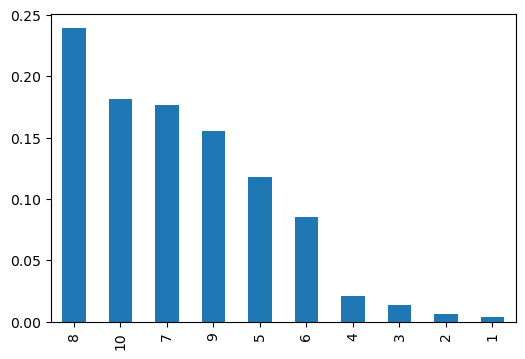

In [9]:
plt.figure(figsize = (6,4))
data['Rating'].value_counts(1).plot(kind='bar')
plt.show()

In [10]:
# data.to_csv('book_rating.csv')

# 2. NON-PERSONALIZED RECOMMENDATIONS

- Non-personalized recommendations: Gợi ý không mang tính cá nhân hóa, dành cho tất cả người dùng mà không tính đến sở thích của họ.
- Một trong những phương pháp non-personalized recommendations được nhóm sử dụng đó là Popularity-based recommendations: gợi ý các sản phẩm phổ biến nhất dựa trên số lượng rating và điểm rating mà không xem xét sở thích cá nhân của người dùng.

![vd_non_person_sr](vd_non_person_rs.png)

In [11]:
data

,UserId,BookId,Rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276736,3257224281,8
4,276737,0600570967,6
...,...,...,...
433666,276704,0806917695,5
433667,276704,1563526298,9
433668,276709,0515107662,10
433669,276721,0590442449,10


## 10 books that most popular

- Đếm số lượng rating cho mỗi quyển sách

In [12]:
book_count = data['BookId'].value_counts() # tự động sắp xếp giảm dần
book_count.describe()

count    185973.000000
mean          2.331903
std           6.834667
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: BookId, dtype: float64

- Chọn những sách có số lượt rating lớn hơn 20

In [13]:
popular_book_id = book_count[book_count > 20].index
popular_book_rankings = data[data['BookId'].isin(popular_book_id)]
popular_book_rankings # df ban đầu chỉ giữ những book có trên 20 ratings

,UserId,BookId,Rating
5,276744,038550120X,7
7,276747,0060517794,9
9,276747,0679776818,8
14,276754,0684867621,8
15,276755,0451166892,5
...,...,...,...
433631,276683,0553262505,7
433642,276688,044661193X,7
433658,276688,0836218655,10
433663,276704,0345386108,6


- Tính trung bình điểm rating cho từng quyển sách

In [14]:
popular_book_average_rankings = popular_book_rankings[['BookId', 'Rating']].groupby('BookId').mean()
popular_book_average_rankings.sort_values(by="Rating", ascending=False).head(10)
# 10 bộ phim phổ biến nhất tính theo số lượng ratings và trung bình rating

,Rating
BookId,
0439425220,9.869565
0618002235,9.720000
8826703132,9.714286
0836220889,9.583333
0743454529,9.545455
0140143505,9.464286
0345339738,9.402597
0060256672,9.400000
0553274325,9.391304


- Trích xuất thông tin của 10 quyển sách phố biến nhất vừa tìm được từ file 'Books.csv'

In [15]:
top10_bookId = popular_book_average_rankings.sort_values(by="Rating", ascending=False).head(10).index
top10_bookId

Index(['0439425220', '0618002235', '8826703132', '0836220889', '0743454529',
       '0140143505', '0345339738', '0060256672', '0553274325', '0156012197'],
      dtype='object', name='BookId')

In [16]:
book_data = pd.read_csv('book/Books.csv')
popular_book_info = book_data[book_data['ISBN'].isin(top10_bookId)]
popular_book_info

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5500\2440566498.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book_data = pd.read_csv('book/Books.csv')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1101,0060256672,Where the Sidewalk Ends : Poems and Drawings,Shel Silverstein,1974,HarperCollins,http://images.amazon.com/images/P/0060256672.0...,http://images.amazon.com/images/P/0060256672.0...,http://images.amazon.com/images/P/0060256672.0...
4206,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...
6814,0156012197,The Little Prince,Antoine de Saint-ExupÃ©ry,2000,Harvest Books,http://images.amazon.com/images/P/0156012197.0...,http://images.amazon.com/images/P/0156012197.0...,http://images.amazon.com/images/P/0156012197.0...
8782,0140143505,84 Charing Cross Road,Helene Hanff,1990,Penguin Books,http://images.amazon.com/images/P/0140143505.0...,http://images.amazon.com/images/P/0140143505.0...,http://images.amazon.com/images/P/0140143505.0...
10287,0553274325,Johnny Got His Gun,Dalton Trumbo,1983,Bantam Books,http://images.amazon.com/images/P/0553274325.0...,http://images.amazon.com/images/P/0553274325.0...,http://images.amazon.com/images/P/0553274325.0...
12762,0618002235,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1999,Houghton Mifflin Company,http://images.amazon.com/images/P/0618002235.0...,http://images.amazon.com/images/P/0618002235.0...,http://images.amazon.com/images/P/0618002235.0...
15187,0836220889,Calvin and Hobbes,Bill Watterson,1987,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836220889.0...,http://images.amazon.com/images/P/0836220889.0...,http://images.amazon.com/images/P/0836220889.0...
30743,0743454529,"My Sister's Keeper : A Novel (Picoult, Jodi)",Jodi Picoult,2004,Atria,http://images.amazon.com/images/P/0743454529.0...,http://images.amazon.com/images/P/0743454529.0...,http://images.amazon.com/images/P/0743454529.0...
79370,0439425220,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,2002,Scholastic,http://images.amazon.com/images/P/0439425220.0...,http://images.amazon.com/images/P/0439425220.0...,http://images.amazon.com/images/P/0439425220.0...


# 3. CONTENT-BASED FILTERING

*   A content-based recommender system cung cấp cho người dùng những gợi ý dựa trên
sự tương đồng về nội dung.

**Ví dụ:** *một user thích đọc tiểu thuyết của Nancy Drew và Agatha Christie, cả hai đều thuộc nhiều thể loại fiction giống nhau. Sau đó, hệ thống gợi ý rằng người dùng cũng nên đọc “Cô gái trên tàu” vì cuốn sách này có thể loại fiction tương tự như những cuốn sách khác mà họ yêu thích.*

*   Lọc dựa trên nội dung là một phương pháp đơn giản để cung cấp các đề xuất dựa
trên sở thích của khách hàng đối với nội dung cụ thể. Tuy nhiên, nhược điểm chính của phương pháp này là nó sẽ không thể gợi ý một sản phẩm mà người dùng chưa từng thấy trước đây.

**Ví dụ:** *người đọc ở trên đọc hai cuốn tiểu thuyết tội phạm và mô hình sẽ không bao giờ gợi ý họ đọc một cuốn sách lãng mạn hoặc hài kịch. Điều này có nghĩa là người dùng sẽ không bao giờ nhận được đề xuất ngoài các thể loại mà họ đã tương tác.*

In [17]:
book_data = pd.read_csv('book/Books.csv', error_bad_lines = False, encoding='latin-1')
book_data

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5500\1201760449.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  book_data = pd.read_csv('book/Books.csv', error_bad_lines = False, encoding='latin-1')


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5500\1201760449.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book_data = pd.read_csv('book/Books.csv', error_bad_lines = False, encoding='latin-1')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [18]:
book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [19]:
book_data.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

*Datafram* trên chứa thông tin của các cuốn sách như *authors, publisher* và *title.*

Chúng ta sẽ sử dụng dữ liệu này để xây dựng *a recommendation system* đề nghị nội dung người dùng nên đọc tiếp theo dựa trên sở thích sách hiện tại của họ.

### remove duplicates

In [20]:
book_data.duplicated(subset='Book-Title').sum()

29225

In [21]:
book_data = book_data.drop_duplicates(subset='Book-Title')
book_data.duplicated(subset='Book-Title').sum() # xác nhận column không còn chứa duplicate value

0

### random sampling: avoid running into memory errors

Lấy mẫu ngẫu nhiên 15.000 hàng từ *dataframe* để tránh gặp phải lỗi bộ nhớ:

In [22]:
sample_size = 15000
df = book_data.sample(n=sample_size, replace=False, random_state=490)

df = df.reset_index()
df = df.drop('index',axis=1)

In [23]:
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0060972491,"Thank You, Jeeves",P.G. Wodehouse,1989,Perennial,http://images.amazon.com/images/P/0060972491.0...,http://images.amazon.com/images/P/0060972491.0...,http://images.amazon.com/images/P/0060972491.0...
1,015602781X,Pincher Martin: The Two Deaths of Christopher ...,William Golding,2002,Harvest Books,http://images.amazon.com/images/P/015602781X.0...,http://images.amazon.com/images/P/015602781X.0...,http://images.amazon.com/images/P/015602781X.0...
2,1561441627,The Nutcracker (Christmas Fun-to-Read Fairy Ta...,Roberta Collier-Morales,1992,Modern Publishing,http://images.amazon.com/images/P/1561441627.0...,http://images.amazon.com/images/P/1561441627.0...,http://images.amazon.com/images/P/1561441627.0...
3,1402708610,I Know a Rhino,Charles Fuge,2003,Sterling,http://images.amazon.com/images/P/1402708610.0...,http://images.amazon.com/images/P/1402708610.0...,http://images.amazon.com/images/P/1402708610.0...
4,0441586325,Norby and the Oldest Dragon,Janet Asimov,1993,Ace Books,http://images.amazon.com/images/P/0441586325.0...,http://images.amazon.com/images/P/0441586325.0...,http://images.amazon.com/images/P/0441586325.0...
...,...,...,...,...,...,...,...,...
14995,1572240687,Taking the Anxiety Out of Taking Tests: A Step...,Susan Johnson,1997,New Harbinger Pubns Inc,http://images.amazon.com/images/P/1572240687.0...,http://images.amazon.com/images/P/1572240687.0...,http://images.amazon.com/images/P/1572240687.0...
14996,157356303X,Encyclopedia of Women's Health Issues,Kathlyn Gay,2001,Oryx Press,http://images.amazon.com/images/P/157356303X.0...,http://images.amazon.com/images/P/157356303X.0...,http://images.amazon.com/images/P/157356303X.0...
14997,067900856X,Fodor's 2002 New York City (Fodor's New York C...,Fodors,2001,Fodor's Travel Publications,http://images.amazon.com/images/P/067900856X.0...,http://images.amazon.com/images/P/067900856X.0...,http://images.amazon.com/images/P/067900856X.0...
14998,0156232057,"C. S. Lewis: A Biography,Revised Edition",Roger Lancelyn Green,1995,Harcourt,http://images.amazon.com/images/P/0156232057.0...,http://images.amazon.com/images/P/0156232057.0...,http://images.amazon.com/images/P/0156232057.0...


### Cleaning text data

*Dataframe* chứa các cột không liên quan đến mô hình, chúng ta chỉ sử dụng các cột 'Title', 'authors', 'publisher' để xây dựng mô hình.

Xóa khoảng trắng khỏi cột “authors”. Nếu chúng ta không làm điều này thì CountVectorizer sẽ tính họ và tên của tác giả là một từ riêng biệt.

**Ví dụ:** Nếu một tác giả tên là *James Clear* và một tác giả khác tên là *James Patterson*, thì công cụ vector hóa sẽ tính từ *James* trong cả hai trường hợp và hệ thống gợi ý có thể coi các cuốn sách rất giống nhau, mặc dù chúng không hề liên quan đến nhau. *James Clear* viết sách *self-help* trong khi *James Patterson* được biết đến với tiểu thuyết bí ẩn.

In [24]:
def clean_text(author):
    result = str(author).lower()
    return(result.replace(' ',''))
df['Book-Author'] = df['Book-Author'].apply(clean_text)
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0060972491,"Thank You, Jeeves",p.g.wodehouse,1989,Perennial,http://images.amazon.com/images/P/0060972491.0...,http://images.amazon.com/images/P/0060972491.0...,http://images.amazon.com/images/P/0060972491.0...
1,015602781X,Pincher Martin: The Two Deaths of Christopher ...,williamgolding,2002,Harvest Books,http://images.amazon.com/images/P/015602781X.0...,http://images.amazon.com/images/P/015602781X.0...,http://images.amazon.com/images/P/015602781X.0...
2,1561441627,The Nutcracker (Christmas Fun-to-Read Fairy Ta...,robertacollier-morales,1992,Modern Publishing,http://images.amazon.com/images/P/1561441627.0...,http://images.amazon.com/images/P/1561441627.0...,http://images.amazon.com/images/P/1561441627.0...
3,1402708610,I Know a Rhino,charlesfuge,2003,Sterling,http://images.amazon.com/images/P/1402708610.0...,http://images.amazon.com/images/P/1402708610.0...,http://images.amazon.com/images/P/1402708610.0...
4,0441586325,Norby and the Oldest Dragon,janetasimov,1993,Ace Books,http://images.amazon.com/images/P/0441586325.0...,http://images.amazon.com/images/P/0441586325.0...,http://images.amazon.com/images/P/0441586325.0...


Chuyển chữ hoa thành chữ thường.

In [25]:
df['Book-Title'] = df['Book-Title'].str.lower()
df['Publisher'] = df['Publisher'].str.lower()

In [26]:
df2 = df.drop(['ISBN', 'Year-Of-Publication',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1)

df2

,Book-Title,Book-Author,Publisher
0,"thank you, jeeves",p.g.wodehouse,perennial
1,pincher martin: the two deaths of christopher ...,williamgolding,harvest books
2,the nutcracker (christmas fun-to-read fairy ta...,robertacollier-morales,modern publishing
3,i know a rhino,charlesfuge,sterling
4,norby and the oldest dragon,janetasimov,ace books
...,...,...,...
14995,taking the anxiety out of taking tests: a step...,susanjohnson,new harbinger pubns inc
14996,encyclopedia of women's health issues,kathlyngay,oryx press
14997,fodor's 2002 new york city (fodor's new york c...,fodors,fodor's travel publications
14998,"c. s. lewis: a biography,revised edition",rogerlancelyngreen,harcourt


Kết hợp ba cột này để tạo một biến duy nhất.

In [27]:
df2['data'] = df2[df2.columns[1:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)

print(df2['data'].head())

0                     p.g.wodehouse perennial
1                williamgolding harvest books
2    robertacollier-morales modern publishing
3                        charlesfuge sterling
4                       janetasimov ace books
Name: data, dtype: object


### Vectorize the Dataframe

Áp dụng CountVectorizer() của Scikit-Learn trên dữ liệu văn bản kết hợp:

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorized = vectorizer.fit_transform(df2['data'])


Biến “vectorized” là một ma trận thưa thớt biểu diễn bằng số của các chuỗi mà chúng ta đã trích xuất.

## Model

Bây giờ, chúng ta sẽ sử dụng thước đo khoảng cách được gọi là *cosine similarity* để tìm ra sự giống nhau giữa mỗi *bag-of-words.* *Cosine similarity* là một số liệu tính toán *cosin* của góc giữa hai hoặc nhiều vectơ để xác định xem chúng có cùng hướng hay không.

*Cosine similarity* nằm trong khoảng từ 0 đến 1. Giá trị 0 biểu thị rằng hai vectơ không giống nhau, 1 cho biết rằng chúng giống hệt nhau.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(vectorized)
#similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [30]:
similarities

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Chúng ta có một vectơ có giá trị nằm trong khoảng từ 1 đến 0 và mỗi vectơ thể hiện sự giống nhau của cuốn sách này với cuốn sách khác.

Vì tên sách không được đề cập ở đây nên chúng ta cần ánh xạ vectơ này trở lại *dataframe* trước đó:

In [31]:
df = pd.DataFrame(similarities, columns=df['Book-Title'], index=df['Book-Title']).reset_index()

df.head()

Book-Title,Book-Title,"thank you, jeeves",pincher martin: the two deaths of christopher martin,the nutcracker (christmas fun-to-read fairy tales ser),i know a rhino,norby and the oldest dragon,his eminence and hizzoner,el oro de los sueãâ±os (leer en espaãâ±ol nivel 4),celestine insights,feng shui and money: a nine-week program for creating wealth using ancient principles and techniques,...,"the santa suit (harlequin american romance, no. 708)",where the gods reign: plants and peoples of the colombian amazon,the terrible troll-bird,virginia embrace (magnolia road),"take 5, volume 4 (under the knife, adam's gift, return to yesterday, everything but time, marriage diamond style)",taking the anxiety out of taking tests: a step-by-step guide,encyclopedia of women's health issues,fodor's 2002 new york city (fodor's new york city),"c. s. lewis: a biography,revised edition",the late night muse: a novel
0,"thank you, jeeves",1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,pincher martin: the two deaths of christopher ...,0.0,1.000000,0.0,0.0,0.333333,0.288675,0.000000,0.288675,0.0,...,0.0,0.0,0.235702,0.288675,0.0,0.0,0.0,0.0,0.0,0.0
2,the nutcracker (christmas fun-to-read fairy ta...,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.223607,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,i know a rhino,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,norby and the oldest dragon,0.0,0.333333,0.0,0.0,1.000000,0.288675,0.000000,0.288675,0.0,...,0.0,0.0,0.235702,0.288675,0.0,0.0,0.0,0.0,0.0,0.0


## Displaying User Recommendations

Sử dụng dataframe ở trên để hiển thị các đề xuất sách. Nếu một cuốn sách được nhập làm đầu vào thì phải trả lại 10 cuốn sách tương tự hàng đầu.

In [32]:
input_book = 'far beyond the stars (star trek deep space nine)'
recommendations = pd.DataFrame(df.nlargest(11,input_book)['Book-Title'])
recommendations = recommendations[recommendations['Book-Title']!=input_book]
print(recommendations)

                                             Book-Title
768    to storm heaven (star trek: the next generation)
802   the star trek chronology : a history of the fu...
1472           gateways #1:  one small step (star trek)
2051           reunion (star trek: the next generation)
2891                marooned (star trek voyager, no 14)
3727     maelstrom (ultima: the technocrat war, book 3)
3991         belle terre (star trek: new earth, book 2)
4567  the way of the warrior (star trek deep space n...
4757  a rock and a hard place:star trek next generat...
5812               the joy machine (star trek, book 80)


# 4. NEIGHBORHOOD-BASED COLLABORATIVE FILTERING

Ý tưởng cơ bản của NBCF là xác định mức độ quan tâm của một user tới một item dựa trên các users khác gần giống với user này. Việc gần giống nhau giữa các users có thể được xác định thông qua mức độ quan tâm của các users này tới các items khác mà hệ thống đã biết. Được phân thành 2 dạng: 
1.   User-based ( Lọc cộng tác dựa trên người dùng ) 
2.   Item-based ( Lọc cộng tác dựa trên sản phẩm )

 ## 1. User-based

- User-based collaborative filtering tập trung vào việc tìm kiếm những người dùng có sở thích tương tự với 1 người dùng cụ thể, sau đó đề xuất các sản phẩm mà những người dùng này đã thích.
-  Ví dụ như nếu người dùng A và B có sở thích giống nhau, và người dùng B thích một sản phẩm mà người dùng A chưa biết đến, thì hệ thống sẽ đề xuất sản phẩm đó cho người dùng A.

<div style="text-align:center;">
    <img src="us-us.jpg" width="600"/>
</div>
<p style="text-align:center; font-style: italic;"> </p>

Source: [here](https://www.argoid.ai/blog/recommendation-systems-basics-concepts/) 

- Đầu vào của bài toán là Utility matrix và công việc quan trọng nhất trong User-based là phải xác định được sự giống nhau giữa hai User và cách xác định sự giống nhau này dựa trên độ quan tâm với các item giữa các User. 

- Tiếp theo chúng ta sẽ xây dựng ma trận chuẩn hóa (normalized utility matrix) bằng cách trừ mỗi rating đi với giá trị trung bình.

<div style="text-align:center;">
    <img src="matrix1.png" width="900"/>
</div>
<p style="text-align:center; font-style: italic;"> Ví dụ mô tả User-user Collaborative Filtering. a) Utility Matrix ban đầu. b) Utility Matrix đã được chuẩn hoá. c) User similarity matrix. d) Dự đoán các (normalized) ratings còn thiếu. e) Ví dụ về cách dự đoán normalized rating của u1 cho i1. f) Dự đoán các (denormalized) ratings còn thiếu. </p>

Source: [here](https://machinelearningcoban.com/2017/05/24/collaborativefiltering/)


**Cosine Similarity:**

similiraty function thường được sử dụng là:
Cosine Similarity để tính độ tương quan(similar) giữa 2 user

<div style="text-align:center;">
    <img src="cos.png" width="700"/>
</div>
<p style="text-align:center; font-style: italic;">

Source: [here](https://machinelearningcoban.com/2017/05/24/collaborativefiltering/)

Độ similarity của hai vector là 1 số trong đoạn [-1, 1]. Giá trị bằng 1 thể hiện hai vector hoàn toàn similar nhau. Giá trị 
cos
 bằng -1 thể hiện hai vector này hoàn toàn trái ngược nhau. Điều này cũng hợp lý , tức khi hành vi của hai users là hoàn toàn ngược nhau thì similarity giữa hai vector đó là thấp nhất.

**Rating prediction**

Trong Collaborative Filtering, missing rating được xác định dựa trên thông tin về 
k
 người dùng có độ tương quan gần nhất. Tất nhiên, chúng ta chỉ quan tâm tới các users đã rated item đang xét. 

<div style="text-align:center;">
    <img src="pre.png" width="700"/>
</div>
<p style="text-align:center; font-style: italic;">

Source: [here](https://machinelearningcoban.com/2017/05/24/collaborativefiltering/)

trong đó 
N(u,i) là tập hợp k
 users trong neighborhood (tức có similarity cao nhất) của 
u
 mà đã rated 
i
.

## 2. Item-based

- Item-based collaborative filtering tập trung vào việc xác định sự tương đồng giữa các sản phẩm và sau đó đề xuất các sản phẩm tương tự với những sản phẩm mà người dùng đã thích.
- Ví dụ : Nếu người dùng A thích một sản phẩm, hệ thống sẽ tìm các sản phẩm tương tự với sản phẩm đó, và đề xuất chúng cho người dùng A.

<div style="text-align:center;">
    <img src="it-it.jpg" width="700"/>
</div>
<p style="text-align:center; font-style: italic;">

Source: [here](https://www.argoid.ai/blog/recommendation-systems-basics-concepts)

Quy trình dự đoán missing ratings cũng tương tự như trong User-user CF

<div style="text-align:center;">
    <img src="matrix2.png" width="700"/>
</div> Ví dụ mô tả Item-Item Collaborative Filtering. a) Utility Matrix ban đầu. b) Utility Matrix đã được chuẩn hoá. c) User similarity matrix. d) Dự đoán các (normalized) ratings còn thiếu.
<p style="text-align:center; font-style: italic;">

Source: [here](https://machinelearningcoban.com/2017/05/24/collaborativefiltering/)

Về mặt tính toán, Item-item CF có thể nhận được từ User-user CF bằng cách chuyển vị (transpose) ma trận utility, và coi như items đang rate users. Sau khi tính ra kết quả cuối cùng, ta lại chuyển vị một lần nữa để thu được kết quả.



- Một số hạn chế của User-user CF:

  - Trên thực tế, số lượng users luôn lớn hơn số lượng items rất nhiều. Nên ma trận tương quan rất lớn => việc lưu trữ ma trận này trong nhiều trường hợp là không khả thi.
  - Ma trận Utility Y thường là rất sparse, tức chỉ có một vài phần tử khác 0. Lý do là users thường lười rating. Cũng chính vì việc này, một khi user đó thay đổi rating hoặc rate thêm items, trung bình cộng các ratings cũng như vector chuẩn hoá tương ứng với user này thay đổi nhiều.Nên việc tính toán ma trận Similarity, vốn tốn nhiều bộ nhớ và thời gian, cũng cần được thực hiện lại.


- Ngược lại, nếu chúng ta tính toán similarity giữa các items rồi recommend những items gần giống với item yêu thích của một user thì sẽ có những lợi ích sau:

  - Vì số lượng items thường nhỏ hơn số lượng users, ma trận tương quan trong trường hợp này cũng nhỏ hơn nhiều, thuận lợi cho việc lưu trữ và tính toán ở các bước sau.
  - Vì số lượng phần tử đã biết trong Utility matrix là như nhau nhưng số hàng (items) ít hơn số cột (users), nên trung bình, mỗi hàng của ma trận này sẽ có nhiều phần tử đã biết hơn số phần tử đã biết trong mỗi cột. (Việc này cũng dễ hiểu vì mỗi item có thể được rated bởi nhiều users).Nên giá trị trung bình của mỗi hàng ít bị thay đổi hơn khi có thêm một vài ratings. Như vậy, việc cập nhật ma trận Similarity Matrix có thể được thực hiện ít thường xuyên hơn.

## Code

### User-User CF

In [33]:
book = pd.read_csv('book/Books.csv')
book

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5500\1316282109.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book = pd.read_csv('book/Books.csv')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [34]:
users = pd.read_csv('book/Users.csv')
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [35]:
user_count = data['UserId'].value_counts() # tự động sắp xếp giảm dần
user_count

11676     8524
98391     5802
153662    1969
189835    1906
23902     1395
          ... 
114079       1
114081       1
114096       1
114115       1
276723       1
Name: UserId, Length: 77805, dtype: int64

In [36]:
user_count.describe()

count    77805.000000
mean         5.573819
std         44.001879
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8524.000000
Name: UserId, dtype: float64

In [37]:
popular_user_id = user_count[user_count > 20].index
amazon1 = data[data['UserId'].isin(popular_user_id)]
amazon1 # df ban đầu chỉ giữ những user rate trên 20 items

,UserId,BookId,Rating
77,276847,3257200552,5
78,276847,3404145909,8
79,276847,3404148576,8
80,276847,3404921178,7
81,276847,3423071516,10
...,...,...,...
433658,276688,0836218655,10
433659,276688,0836236688,10
433660,276688,0892966548,10
433661,276688,1551669315,6


In [38]:
print('Number of unique USERS = ', amazon1['UserId'].nunique())
print('Number of unique ITEMS = ', amazon1['BookId'].nunique())

Number of unique USERS =  3521
Number of unique ITEMS =  128866


In [39]:
# Tạo bảng ánh xạ cho UserId
UserId_mapping_us= {UserId: i for i, UserId in enumerate(amazon1['UserId'].unique())}

In [40]:
# Tạo bảng ánh xạ cho ProductId
ProductId_mapping_us = {ProductId: i for i, ProductId in enumerate(amazon1['BookId'].unique())}

In [41]:
# Chuyển đổi UserId và ProductId thành kiểu số nguyên (giá trị bắt đầu từ 0)
amazon1['UserId'] = amazon1['UserId'].map(UserId_mapping_us)
amazon1['BookId'] = amazon1['BookId'].map(ProductId_mapping_us)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5500\2002594536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon1['UserId'] = amazon1['UserId'].map(UserId_mapping_us)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5500\2002594536.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon1['BookId'] = amazon1['BookId'].map(ProductId_mapping_us)


In [42]:
amazon1.iloc[0:1000]

,UserId,BookId,Rating
77,0,0,5
78,0,1,8
79,0,2,8
80,0,3,7
81,0,4,10
...,...,...,...
2635,19,984,5
2664,20,985,7
2665,20,986,9
2666,20,987,7


In [43]:
# class Collaborative Filtering 

class CF(object):
    """docstring for CF"""
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
    
    def add(self, new_data):
        """
        Update Y_data matrix when new ratings come.
        For simplicity, suppose that there is no new user or item.
        """
        self.Y_data = np.concatenate((self.Y_data, new_data), axis = 0)
    
    def normalize_Y(self):
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important 
        # for both memory and computing efficiency. For example, if #user = 1M, 
        # #item = 100k, then shape of the rating matrix would be (100k, 1M), 
        # you may not have enough memory to store this. Then, instead, we store 
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],(self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        eps = 1e-6
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
    
        
    def refresh(self):
        """
        Normalize data and calculate similarity matrix again (after
        some few ratings added)
        """
        self.normalize_Y()
        self.similarity() 
        
    def fit_data(self):
        self.refresh()
        
    
    def __pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (if normalized =1 )
        if you need the un
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        # Step 2: 
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        u = int(u)
        i = int(i)

        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized=1)
        predict the rating of item i for user u (normalized=0)
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
            
    
    def recommend(self, u):
        """
        Determine all items should be recommended for user u. (uuCF =1)
        or all users who might have interest on item u (uuCF = 0)
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_items.append(i)
        
        return recommended_items 

    def print_recommendation(self):
        """
        print all items which should be recommended for each user 
        """
        print('Recommendation for 3 first user ')
        for u in range(3):       
            recommended_items = self.recommend(u)
            if self.uuCF:
                print ('Recommend item(s):', recommended_items, 'for user', u)
            else: 
                print ('Recommend item', u, 'for user(s) : ', recommended_items)

In [44]:
train_data_us, test_data_us = train_test_split(amazon1, test_size=0.3, random_state=43)                         
train_us =train_data_us.values
test_us =test_data_us.values
print(f'Số lượng user trên tập train {int(np.max(train_us[:, 0])) + 1}' )
print(f'Số lượng item trên tập train {int(np.max(train_us[:, 1])) + 1}' )
print(f'Số lượng user trên tập test {int(np.max(test_us[:, 0])) + 1}' )
print(f'Số lượng item trên tập test {int(np.max(test_us[:, 1])) + 1}' )

Số lượng user trên tập train 3521
Số lượng item trên tập train 128866
Số lượng user trên tập test 3521
Số lượng item trên tập test 128864


In [45]:
rs_us = CF(train_us, k = 5, uuCF = 1)
rs_us.fit_data()
n_tests_us = test_us.shape[0]
SE = 0 # squared error
for n in range(n_tests_us):
    pred = rs_us.pred(test_us[n, 0], test_us[n, 1], normalized = 0)
    SE += (pred - test_us[n, 2])**2 

RMSE = np.sqrt(SE/n_tests_us)
print( 'User-Based CF test, RMSE =', RMSE)

User-Based CF test, RMSE = 1.6272609162094516


In [46]:
rs_us = CF(train_us, k = 5, uuCF = 1)
rs_us.fit_data()
n_trains_us = train_us.shape[0]
SE = 0 # squared error
for n in range(n_trains_us):
    pred = rs_us.pred(train_us[n, 0], train_us[n, 1], normalized = 0)
    SE += (pred - train_us[n, 2])**2 

RMSE = np.sqrt(SE/n_trains_us)
print( 'User-based CF train, RMSE =', RMSE)

User-based CF train, RMSE = 0.5263214039177709


In [47]:
#Recommendation for 3 first user 
rs_us.print_recommendation()

Recommendation for 3 first user 
Recommend item(s): [24, 4272, 5300, 5422, 6760, 14466, 19843, 22175, 22538, 27608, 29925, 30011, 30121, 33351, 33352, 34277, 37898, 42400, 44023, 48415, 48971, 49592, 49593, 52871, 68434, 68447, 68448, 75740, 80824, 81274, 82840, 83515, 83518, 83530, 83531, 85216, 90887, 90888, 90892, 90893, 104478, 104481, 104482, 104485, 106119, 106130, 106134, 106991, 106998, 106999, 117317] for user 0
Recommend item(s): [6976, 6977, 6980, 6988, 6991, 6992, 6994, 6999, 7004, 7005, 7007, 7010, 7014, 7018, 7020, 7023, 7027, 7029, 7038, 7039, 7040, 7052, 7055, 7057, 7065, 7066, 7068, 7074, 7076, 7077, 7095, 7096, 7102, 7105, 7106, 7109, 7110, 7115, 7120, 7125, 7135, 7138, 7140, 7142, 7147, 7148, 7150, 7159, 7160, 7164, 31967, 38706, 38724, 38732, 38734, 38737, 38738, 38739, 38740, 38741, 38742, 38751, 55824, 95115, 95165, 95175, 95228] for user 1
Recommend item(s): [50040, 50044, 50048, 50052, 50053, 50055, 50057, 50058] for user 2


In [48]:
def recommend_books_for_original_user(user_id, model, user_id_mapping, books_data):
    # Ánh xạ user_id từ người dùng có id gốc 
    mapped_user_id = user_id_mapping.get(user_id, None)
    
    if mapped_user_id is None:
        print(f"User ID {user_id} not found in the mapping.")
        return None

    recommended_books = model.recommend(mapped_user_id)

    # Ánh xạ ngược từ các sách đã recommend về giá trị gốc
    original_books = [original_id for original_id, mapped_id in ProductId_mapping_us.items() if mapped_id in recommended_books]

    # Lấy thông tin về sách từ các ID sách đã recommend
    recommended_books_info = books_data[books_data['ISBN'].isin(original_books)]
    
    return recommended_books_info[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-L']]

In [49]:
# Sử dụng hàm recommend_books_for_original_user để đề xuất sách cho người dùng có user_id = '276847'
user_id_to_recommend = 276847
recommended_books_info = recommend_books_for_original_user(user_id_to_recommend, rs_us, UserId_mapping_us, book)
recommended_books_info

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
921,3404118960,Die SÃ?Â¤ulen der Erde. Roman.,Ken Follett,1992,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404118960.0...
3361,3423205202,Mittsommermord. Roman.,Henning Mankell,2002,Dtv,http://images.amazon.com/images/P/3423205202.0...
4101,0399143947,Point of Origin,Patricia Daniels Cornwell,1998,Putnam Pub Group,http://images.amazon.com/images/P/0399143947.0...
4578,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999,Scribner,http://images.amazon.com/images/P/0684872153.0...
4899,014027944X,Armadillo,William Boyd,0,Penguin Putnam~trade,http://images.amazon.com/images/P/014027944X.0...
5794,3453127013,Der Regenmacher.,John Grisham,1997,Heyne,http://images.amazon.com/images/P/3453127013.0...
9999,3404144783,Dunkel.,Wolfgang Hohlbein,2001,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404144783.0...
19498,0385413017,Fumblerules: A Lighthearted Guide to Grammar a...,William Safire,1990,Bantam Dell Pub Group,http://images.amazon.com/images/P/0385413017.0...
28790,0451403886,King Solomon's Carpet,Barbara Vine,1993,Onyx Books,http://images.amazon.com/images/P/0451403886.0...
34538,3551551677,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999,Carlsen Verlag GmbH,http://images.amazon.com/images/P/3551551677.0...


In [50]:
target_value = 24
matching_keys = [key for key, value in ProductId_mapping_us.items() if value == target_value]
# In kết quả
print(matching_keys)

['3551551677']


### Item-Item CF

In [51]:
# Create a list of only book appearing > 20 times in the dataset
book_count = data['BookId'].value_counts() 
book_count

0316666343     707
0971880107     581
0385504209     487
0312195516     383
0679781587     333
              ... 
0140441905       1
0886777267       1
0671697951       1
0553560956       1
05162443314      1
Name: BookId, Length: 185973, dtype: int64

In [52]:
book_count.describe()

count    185973.000000
mean          2.331903
std           6.834667
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: BookId, dtype: float64

In [53]:
popular_book_id = book_count[book_count > 20].index
amazon2 = data[data['BookId'].isin(popular_book_id)]
amazon2 # df ban đầu chỉ giữ những book có trên 20 ratings

,UserId,BookId,Rating
5,276744,038550120X,7
7,276747,0060517794,9
9,276747,0679776818,8
14,276754,0684867621,8
15,276755,0451166892,5
...,...,...,...
433631,276683,0553262505,7
433642,276688,044661193X,7
433658,276688,0836218655,10
433663,276704,0345386108,6


In [54]:
print('Number of unique USERS = ', amazon2['UserId'].nunique())
print('Number of unique ITEMS = ', amazon2['BookId'].nunique())

Number of unique USERS =  31396
Number of unique ITEMS =  2034


In [55]:
# Tạo bảng ánh xạ cho UserId
UserId_mapping_it = {UserId: i for i, UserId in enumerate(amazon2['UserId'].unique())}

In [56]:
# Tạo bảng ánh xạ cho ProductId
ProductId_mapping_it = {ProductId: i for i, ProductId in enumerate(amazon2['BookId'].unique())}

In [57]:
# Chuyển đổi UserId và ProductId thành kiểu số nguyên
amazon2['UserId'] = amazon2['UserId'].map(UserId_mapping_it)
amazon2['BookId'] = amazon2['BookId'].map(ProductId_mapping_it)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5500\1795503247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon2['UserId'] = amazon2['UserId'].map(UserId_mapping_it)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5500\1795503247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon2['BookId'] = amazon2['BookId'].map(ProductId_mapping_it)


In [58]:
amazon2.iloc[0:1000]

,UserId,BookId,Rating
5,0,0,7
7,1,1,9
9,1,2,8
14,2,3,8
15,3,4,5
...,...,...,...
4253,421,695,5
4262,422,148,5
4265,422,466,10
4268,423,627,8


In [59]:
train_data_it, test_data_it = train_test_split(amazon2, test_size=0.3, random_state=43)
train_it =train_data_it.values
test_it =test_data_it.values
print(f'Số lượng user trên tập train {int(np.max(train_it[:, 0])) + 1}' )
print(f'Số lượng item trên tập train {int(np.max(train_it[:, 1])) + 1}' )
print(f'Số lượng user trên tập test {int(np.max(test_it[:, 0])) + 1}' )
print(f'Số lượng item trên tập test {int(np.max(test_it[:, 1])) + 1}' )

Số lượng user trên tập train 31396
Số lượng item trên tập train 2034
Số lượng user trên tập test 31396
Số lượng item trên tập test 2034


In [60]:
rs_it = CF(train_it, k = 5, uuCF = 0)
rs_it.fit_data()

n_tests_it = test_it.shape[0]
SE = 0 # squared error
for n in range(n_tests_it):
    pred = rs_it.pred(test_it[n, 0], test_it[n, 1], normalized = 0)
    SE += (pred - test_it[n, 2])**2 

RMSE = np.sqrt(SE/n_tests_it)
print ('Item-item CF test, RMSE =', RMSE)

Item-item CF test, RMSE = 1.7365470152214193


In [61]:
rs_it = CF(train_it, k = 5, uuCF = 0)
rs_it.fit_data()

n_trains_it = train_it.shape[0]
SE = 0 # squared error
for n in range(n_trains_it):
    pred = rs_it.pred(train_it[n, 0], train_it[n, 1], normalized = 0)
    SE += (pred - train_it[n, 2])**2 

RMSE = np.sqrt(SE/n_trains_it)
print ('Item-item CF train, RMSE =', RMSE)

Item-item CF train, RMSE = 0.5409447388628792


In [62]:
def recommend_users_for_item(item_id, model, item_id_mapping, users_data):
    # Ánh xạ item_id từ id gốc 
    mapped_item_id = item_id_mapping.get(item_id, None)
    
    if mapped_item_id is None:
        print(f"Item ID {item_id} not found in the mapping.")
        return None

    recommended_users = model.recommend(mapped_item_id)

    # Ánh xạ ngược từ các người dùng đã recommend về giá trị gốc
    original_users = [original_id for original_id, mapped_id in UserId_mapping_us.items() if mapped_id in recommended_users]

    # Lấy thông tin về người dùng từ các ID người dùng đã recommend
    recommended_users_info = users_data[users_data['User-ID'].isin(original_users)]
    
    return recommended_users_info[['User-ID', 'Location','Age']]

In [63]:
# Sử dụng hàm recommend_users_for_item để đề xuất user cho item có id là '0316666343'
book_id_to_recommend = '0316666343'
recommended_users_info = recommend_users_for_item(book_id_to_recommend, rs_it, ProductId_mapping_it, users)
recommended_users_info

,User-ID,Location,Age
241,242,"neuffen, baden-wuerttemberg, germany",37.0
391,392,"barcelona, catalunya, spain",44.0
506,507,"dumas, arkansas, usa",NaN
1434,1435,"st. louis, missouri, usa",36.0
1847,1848,"bellingham, washington, usa",22.0
...,...,...,...
276486,276487,"teruel, aragon, spain",21.0
278187,278188,"lake george, new york, usa",34.0
278417,278418,"omaha, nebraska, usa",NaN
278581,278582,"slidell, louisiana, usa",NaN


# 5. MATRIX FACTORIZATION CF - SVD

- Việc phân tích một ma trận ra thành tích của nhiều ma trận đặc biệt khác (Matrix Factorization hoặc Matrix Decomposition) mang lại nhiều ích lợi quan trọng mà các bạn sẽ thấy: giảm số chiều dữ liệu, nén dữ liệu, tìm hiểu các đặc tính của dữ liệu, giải các hệ phương trình tuyến tính, clustering, và nhiều ứng dụng khác. Recommendation System cũng là một trong rất nhiều ứng dụng của Matrix Factorization.
- Singular Value Decomposition (SVD) là một trong những phương pháp Matrix Factorization. Ý tưởng chính của phương pháp này đó là: mọi ma trận, không nhất thiết là vuông, đều có thể được phân tích thành tích của ba ma trận đặc biệt.

### Phát biểu SVD
Một ma trận $\mathbf{A}_{{m \times n}}$ bất kỳ đều có thể phân tích thành dạng: $$\mathbf{A}_{{m \times n}} = \mathbf{U}_{{m \times m}}\mathbf{Σ}_{{m \times n}}(\mathbf{V}_{{n \times n}})ᵀ$$
Trong đó, $\mathbf{U}, \mathbf{V}$ là các ma trận trực giao, $\mathbf{Σ}$ là ma trận đường chéo không vuông với các phần tử trên đường chéo $σ_{1} ≥ σ_{2} ≥ ... ≥ σ_{r} ≥ 0 = 0 = ... = 0$ và $\mathbf{r}$ là rank của ma trận $\mathbf{A}$. Mặc dù $\mathbf{Σ}$ không phải ma trận vuông, ta vẫn có thể coi nó là ma trận chéo nếu các thành phần khác không của nó chỉ nằm ở vị trí đường chéo, tức tại các vị trí có chỉ số hàng và chỉ số cột là như nhau.
Số lượng các phần tử khác 0 trong $\mathbf{Σ}$ chính là rank của ma trận $\mathbf{A}$.


![svd](svd.png)

Như vậy, ta sẽ xấp xỉ Utility Matrix đã được chuẩn hoá.

## Preprocessing

In [64]:
data

,UserId,BookId,Rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276736,3257224281,8
4,276737,0600570967,6
...,...,...,...
433666,276704,0806917695,5
433667,276704,1563526298,9
433668,276709,0515107662,10
433669,276721,0590442449,10


In [65]:
# Create a list of only users appearing > 20 times in the dataset
user_count = data['UserId'].value_counts() # tự động sắp xếp giảm dần
user_count.describe()

count    77805.000000
mean         5.573819
std         44.001879
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8524.000000
Name: UserId, dtype: float64

In [66]:
popular_user_id = user_count[user_count > 20].index
popular_user_rankings = data[data['UserId'].isin(popular_user_id)]
popular_user_rankings # df ban đầu chỉ giữ những book có trên 20 ratings

,UserId,BookId,Rating
77,276847,3257200552,5
78,276847,3404145909,8
79,276847,3404148576,8
80,276847,3404921178,7
81,276847,3423071516,10
...,...,...,...
433658,276688,0836218655,10
433659,276688,0836236688,10
433660,276688,0892966548,10
433661,276688,1551669315,6


- Create pivot table

In [67]:
pivot_table = popular_user_rankings.pivot(index='UserId', columns='BookId', values='Rating')

# Đặt tên cho các cột mới
pivot_table.columns = [f'{col}' for col in pivot_table.columns]

# Hiển thị kết quả
print(pivot_table)

         0375404120   9022906116  0 00 655241 2  0 14 02.9640  0 297 64548 X  \
UserId                                                                         
183             NaN          NaN            NaN           NaN            NaN   
242             NaN          NaN            NaN           NaN            NaN   
254             NaN          NaN            NaN           NaN            NaN   
392             NaN          NaN            NaN           NaN            NaN   
507             NaN          NaN            NaN           NaN            NaN   
...             ...          ...            ...           ...            ...   
278221          NaN          NaN            NaN           NaN            NaN   
278356          NaN          NaN            NaN           NaN            NaN   
278418          NaN          NaN            NaN           NaN            NaN   
278582          NaN          NaN            NaN           NaN            NaN   
278633          NaN          NaN        

- Giữ lại một phần data cho tập test lưu trong biến actual_values

In [68]:
actual_values = deepcopy(pivot_table.iloc[:300,:12000])
non_nan = actual_values.count().sum()
non_nan

2913

- Vì data cho tập train không chứa data của tập test nên gán np.nan ở các vị trí đã trích xuất cho tập test

In [69]:
pivot_table.iloc[:300,:12000] = np.nan

Center each user's ratings around 0: Chuẩn hóa (center) các rating xung quanh 0 là quá trình điều chỉnh các giá trị rating trong một ma trận sao cho giá trị trung bình của từng hàng hoặc cột (trong trường hợp này là từng người dùng) là 0. Mục đích:
- Loại bỏ bias người dùng hoặc sản phẩm: Chuẩn hóa giúp loại bỏ sự chênh lệch giữa các người dùng hoặc sản phẩm trong hệ thống recommendation. Điều này giúp mô hình dự đoán dựa trên sự tương đồng giữa các người dùng hoặc sản phẩm mà không bị ảnh hưởng quá mức bởi các rating được đánh giá mà có thể do sở thích cá nhân hoặc thiên hướng đặc biệt của một người dùng.
- Cải thiện khả năng dự đoán: Chuẩn hóa giúp tạo ra một ma trận có tính kỷ luật hơn, giúp mô hình dự đoán tốt hơn bằng cách loại bỏ ảnh hưởng của các đánh giá có thể không cân nhắc hoặc thiên lệch.
- Tính toán SVD dễ dàng hơn: Trong phân rã giá trị riêng (SVD) hoặc các phương pháp factorization khác, việc chuẩn hóa giúp đơn giản hóa quá trình tính toán và phân rã, làm cho các ma trận tương đối "đơn giản" hơn và giảm thiểu việc tính toán các giá trị riêng không mong muốn.
- Cải thiện hiệu suất mô hình: Việc loại bỏ bias hoặc ảnh hưởng không mong muốn có thể cải thiện hiệu suất của mô hình recommendation system, giúp mô hình dự đoán chính xác hơn và đưa ra các đề xuất phù hợp hơn cho người dùng.

In [70]:
# trung bình của mỗi hàng/user 
avg_ratings = pivot_table.mean(axis=1)
avg_ratings.sort_values()

UserId
204167     3.708333
266824     4.310345
138018     4.409091
235805     4.483871
246823     4.557377
            ...    
52521     10.000000
187425    10.000000
12272     10.000000
167455    10.000000
182086    10.000000
Length: 3521, dtype: float64

In [71]:
# check is nan
avg_ratings.isna().sum()

0

In [72]:
# Center each user's ratings around 0
# trừ từng giá trị của mỗi hàng cho giá trị trung bình tương ứng
user_ratings_centered = pivot_table.sub(avg_ratings, axis=0)
user_ratings_centered

,0375404120,9022906116,0 00 655241 2,0 14 02.9640,0 297 64548 X,0 330 10597 3,0 671 74251 5,0 907 062 008,0*708880258,0+399139745,...,SBN67001026X,UNGRANDHOMMED,X000000000,Z380703475,ZR903CX0003,"\0432534220\""""","\2842053052\""""","\8887517452\""""","\8888809228\""""",Ô½crosoft
UserId,,,,,,,,,,,,,,,,,,,,,
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Điền 0 cho các giá trị nan

In [73]:
user_ratings_centered.fillna(0, inplace=True)

In [74]:
print(user_ratings_centered)

         0375404120   9022906116  0 00 655241 2  0 14 02.9640  0 297 64548 X  \
UserId                                                                         
183             0.0          0.0            0.0           0.0            0.0   
242             0.0          0.0            0.0           0.0            0.0   
254             0.0          0.0            0.0           0.0            0.0   
392             0.0          0.0            0.0           0.0            0.0   
507             0.0          0.0            0.0           0.0            0.0   
...             ...          ...            ...           ...            ...   
278221          0.0          0.0            0.0           0.0            0.0   
278356          0.0          0.0            0.0           0.0            0.0   
278418          0.0          0.0            0.0           0.0            0.0   
278582          0.0          0.0            0.0           0.0            0.0   
278633          0.0          0.0        

## Model

- Sử dụng hàm svds() trong thư viện SciPy (Scientific Python) để phân rã giá trị riêng (Singular Value Decomposition - SVD) trên ma trận thưa (sparse matrix).
- U, sigma, Vt = svds(A, k=6) với tham số truyền vào bao gồm A là một ma trận thưa được sử dụng để thực hiện SVD, k là số lượng giá trị singular values lớn nhất cần trích xuất, mặc định là 6.

Các giá trị trả về từ hàm svds() bao gồm:

- U: Là ma trận chứa các vectors cột ứng với các giá trị riêng trái (left singular vectors).
- sigma: Là một array chứa các giá trị singular values.
- Vt: Là ma trận chuyển vị của ma trận chứa các vectors hàng ứng với các giá trị riêng phải (right singular vectors).

In [75]:
# Import the required libraries 
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

# Chuyển đổi ma trận dày đặc thành ma trận thưa
user_ratings_centered_sparse = csr_matrix(user_ratings_centered)

# Sử dụng hàm svds() trên ma trận thưa
U, sigma, Vt = svds(user_ratings_centered_sparse)

In [76]:
user_ratings_centered_sparse

<3521x128866 sparse matrix of type '<class 'numpy.float64'>'
	with 237906 stored elements in Compressed Sparse Row format>

In [77]:
print(U.shape)
print(Vt.shape)
print(sigma.shape)

(3521, 6)
(6, 128866)
(6,)


In [78]:
sigma = np.diag(sigma)
print(sigma)

[[ 51.43116855   0.           0.           0.           0.
    0.        ]
 [  0.          55.90599504   0.           0.           0.
    0.        ]
 [  0.           0.          63.88763133   0.           0.
    0.        ]
 [  0.           0.           0.          73.06866359   0.
    0.        ]
 [  0.           0.           0.           0.          74.74059429
    0.        ]
 [  0.           0.           0.           0.           0.
  179.22629916]]


- Nhân cách factors lại với nhau để được ma trận đầy đủ cần tìm

In [79]:
# Dot product of U and sigma
U_sigma = np.dot(U, sigma)

# Dot product of result and Vt
U_sigma_Vt = np.dot(U_sigma, Vt)
U_sigma_Vt

array([[ 2.59158101e-10,  1.66574353e-23,  2.87726890e-12, ...,
         1.85682254e-11, -8.95643811e-11,  4.32756969e-11],
       [ 3.01459185e-08, -4.08341171e-19, -3.24696217e-08, ...,
        -8.93148490e-08,  4.30812801e-07, -6.20036023e-09],
       [ 1.18715979e-08,  9.84324248e-19,  9.40709940e-08, ...,
         1.59934933e-07, -7.71450853e-07, -2.36259185e-07],
       ...,
       [-7.44480716e-08,  1.92958654e-18,  1.41145018e-07, ...,
         2.68036753e-07, -1.29288316e-06, -2.38820566e-07],
       [-1.42787365e-07,  1.84119988e-18,  1.69322834e-07, ...,
         4.54749601e-07, -2.19349807e-06, -2.97572035e-08],
       [ 5.08535297e-08,  4.37501344e-19,  3.49462371e-08, ...,
         4.28883937e-08, -2.06873428e-07, -1.16306966e-07]])

- Cộng giá trị trung bình đã chuẩn hóa trước đó

In [80]:
U_sigma_Vt.shape

(3521, 128866)

In [81]:
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1, 1)
uncentered_ratings

array([[8.        , 8.        , 8.        , ..., 8.        , 8.        ,
        8.        ],
       [8.54545458, 8.54545455, 8.54545451, ..., 8.54545446, 8.54545498,
        8.54545454],
       [7.82692309, 7.82692308, 7.82692317, ..., 7.82692324, 7.82692231,
        7.82692284],
       ...,
       [6.1709401 , 6.17094017, 6.17094031, ..., 6.17094044, 6.17093888,
        6.17093993],
       [7.63888875, 7.63888889, 7.63888906, ..., 7.63888934, 7.6388867 ,
        7.63888886],
       [7.2954546 , 7.29545455, 7.29545458, ..., 7.29545459, 7.29545434,
        7.29545443]])

- Chuyển sang DataFrame

In [82]:
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, 
                                    index=pivot_table.index,
                                    columns=pivot_table.columns
                                   )
# Print both the recalculated matrix and the original 
print(calc_pred_ratings_df)


         0375404120   9022906116  0 00 655241 2  0 14 02.9640  0 297 64548 X  \
UserId                                                                         
183        8.000000     8.000000       8.000000      8.000000       8.000000   
242        8.545455     8.545455       8.545455      8.545455       8.545455   
254        7.826923     7.826923       7.826923      7.826923       7.826923   
392        6.809524     6.809524       6.809524      6.809524       6.809524   
507        7.939394     7.939394       7.939394      7.939394       7.939394   
...             ...          ...            ...           ...            ...   
278221     8.846154     8.846154       8.846154      8.846154       8.846154   
278356     8.138889     8.138889       8.138889      8.138889       8.138889   
278418     6.170940     6.170940       6.170940      6.170940       6.170940   
278582     7.638889     7.638889       7.638889      7.638889       7.638889   
278633     7.295455     7.295455       7

## Evaluate RMSE (Root Mean Squared Error)

- Ma trận thực tế

In [83]:
actual_values

,0375404120,9022906116,0 00 655241 2,0 14 02.9640,0 297 64548 X,0 330 10597 3,0 671 74251 5,0 907 062 008,0*708880258,0+399139745,...,0155003771,0155003801,0155006614,0155016881,0155017500,0155017969,0155023616,0155026607,0155033379,0155034731
UserId,,,,,,,,,,,,,,,,,,,,,
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Ma trận đã được dự đoán

In [84]:
predicted_values = calc_pred_ratings_df.iloc[:300,:12000]
predicted_values

,0375404120,9022906116,0 00 655241 2,0 14 02.9640,0 297 64548 X,0 330 10597 3,0 671 74251 5,0 907 062 008,0*708880258,0+399139745,...,0155003771,0155003801,0155006614,0155016881,0155017500,0155017969,0155023616,0155026607,0155033379,0155034731
UserId,,,,,,,,,,,,,,,,,,,,,
183,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
242,8.545455,8.545455,8.545455,8.545455,8.545455,8.545455,8.545455,8.545455,8.545454,8.545455,...,8.545455,8.545455,8.545454,8.545455,8.545454,8.545771,8.545455,8.545455,8.545454,8.545455
254,7.826923,7.826923,7.826923,7.826923,7.826923,7.826923,7.826923,7.826923,7.826923,7.826923,...,7.826923,7.826919,7.826923,7.826923,7.826889,7.827644,7.826923,7.826923,7.826923,7.826920
392,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,...,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524,6.809524
507,7.939394,7.939394,7.939394,7.939394,7.939394,7.939394,7.939394,7.939394,7.939394,7.939394,...,7.939394,7.939394,7.939394,7.939394,7.939401,7.939401,7.939394,7.939394,7.939394,7.939394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24921,8.454546,8.454545,8.454545,8.454545,8.454545,8.454545,8.454545,8.454546,8.454545,8.454545,...,8.454545,8.454546,8.454546,8.454546,8.454549,8.454911,8.454545,8.454545,8.454545,8.454546
24933,6.873016,6.873016,6.873016,6.873016,6.873016,6.873016,6.873016,6.873016,6.873016,6.873016,...,6.873016,6.873017,6.873015,6.873016,6.873013,6.874588,6.873016,6.873016,6.873015,6.873015
24934,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,...,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333,7.333333


In [85]:
# Tạo mask cho các ô không phải NaN trong ma trận thực tế
mask = ~np.isnan(actual_values.values)

In [86]:
actual = deepcopy(actual_values.values[mask])
predicted = deepcopy(predicted_values.values[mask])

In [87]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(actual, predicted, squared=False))

1.6547766926697818


RMSE = 1.6547766926697818 (trên thang rating là 10) cho thấy model thực hiện khá tốt, có thể chấp nhận và sử dụng được.

In [88]:
predicted_values.index

Int64Index([  183,   242,   254,   392,   507,   638,   643,   651,   709,
              805,
            ...
            24433, 24440, 24624, 24641, 24733, 24921, 24933, 24934, 25131,
            25409],
           dtype='int64', name='UserId', length=300)

## Recommend for user

In [89]:
def svd_recommendation(predicted_ratings_df, user_id, n):
    return predicted_ratings_df.loc[user_id].nlargest(n).index

In [90]:
rcm_id = svd_recommendation(calc_pred_ratings_df, 183, 10)

In [91]:
rcm_book = book_data[book_data['ISBN'].isin(rcm_id)]
rcm_book

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
41183,1570820872,Disney's the Lion King (Disney Classic Series),Don Ferguson,1994,Random House Childrens Pub,http://images.amazon.com/images/P/1570820872.0...,http://images.amazon.com/images/P/1570820872.0...,http://images.amazon.com/images/P/1570820872.0...
48759,030712908X,Toy Story,Betty Birney,1995,Golden Books,http://images.amazon.com/images/P/030712908X.0...,http://images.amazon.com/images/P/030712908X.0...,http://images.amazon.com/images/P/030712908X.0...
60135,0590464388,"Fraidy Cats (Hello Reader, Level 2)",Stephen Krensky,1993,Scholastic,http://images.amazon.com/images/P/0590464388.0...,http://images.amazon.com/images/P/0590464388.0...,http://images.amazon.com/images/P/0590464388.0...
76404,0307129209,Casper/Friends Forever,Golden Books,1999,Golden Books,http://images.amazon.com/images/P/0307129209.0...,http://images.amazon.com/images/P/0307129209.0...,http://images.amazon.com/images/P/0307129209.0...
76432,0153050047,Being Healthy 1994: Grade 8,Harcourt Brace Publishing,1994,Henry Holt &amp; Company,http://images.amazon.com/images/P/0153050047.0...,http://images.amazon.com/images/P/0153050047.0...,http://images.amazon.com/images/P/0153050047.0...
76457,0026638959,Human Heritage,Miriam S. Greenblatt,1999,Glencoe/McGraw-Hill,http://images.amazon.com/images/P/0026638959.0...,http://images.amazon.com/images/P/0026638959.0...,http://images.amazon.com/images/P/0026638959.0...
76510,0307086984,Galactic Adventures (Star Wars (Econo-Clad Har...,Golden,1999,Golden Books,http://images.amazon.com/images/P/0307086984.0...,http://images.amazon.com/images/P/0307086984.0...,http://images.amazon.com/images/P/0307086984.0...
76585,0134005651,Sound and Light/Student Text,Not Applicable (Na ),1994,Pearson Prentice Hall,http://images.amazon.com/images/P/0134005651.0...,http://images.amazon.com/images/P/0134005651.0...,http://images.amazon.com/images/P/0134005651.0...
76623,0201690179,Scott Foresman Addison Wesley Middle School Ma...,Not Applicable (Na ),1998,Pearson Prentice Hall,http://images.amazon.com/images/P/0201690179.0...,http://images.amazon.com/images/P/0201690179.0...,http://images.amazon.com/images/P/0201690179.0...
